In [1]:
# -*- coding: utf-8 -*-
# 美吉姆走势预测，使用时间序列ARMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')
# 数据加载
df = pd.read_csv('002621_2011_9_20_to_2020_9_4.csv')
df = df[['Timestamp', 'Price']]

In [2]:
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())

            Timestamp  Price
Timestamp                   
2020-09-04 2020-09-04   7.10
2020-09-03 2020-09-03   7.15
2020-09-02 2020-09-02   7.16
2020-09-01 2020-09-01   7.15
2020-08-31 2020-08-31   7.20


In [3]:
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)
#print(df_Q)
#print(df_year)

                Price
Timestamp            
2011-09-30  15.590000
2011-10-31  25.367500
2011-11-30  26.827727
2011-12-31  22.894545
2012-01-31  20.243333
2012-02-29  22.527619
2012-03-31  22.050000
2012-04-30  13.653529
2012-05-31  13.848182
2012-06-30  14.032000
2012-07-31  11.274091
2012-08-31  11.367391
2012-09-30  11.408500
2012-10-31  11.420000
2012-11-30  11.025909
2012-12-31  11.286190
2013-01-31  11.942000
2013-02-28  12.126000
2013-03-31  12.717619
2013-04-30  11.426111
2013-05-31  11.722273
2013-06-30  12.394706
2013-07-31  12.399565
2013-08-31  12.492727
2013-09-30  12.739474
2013-10-31  12.845556
2013-11-30  12.629524
2013-12-31  13.919091
2014-01-31  13.603810
2014-02-28  14.907500
...               ...
2018-04-30  14.087778
2018-05-31  15.071818
2018-06-30   3.820500
2018-07-31  14.875000
2018-08-31  17.306087
2018-09-30  16.825789
2018-10-31  14.524444
2018-11-30  17.255000
2018-12-31  18.066000
2019-01-31  20.065000
2019-02-28  21.832667
2019-03-31  23.090952
2019-04-30

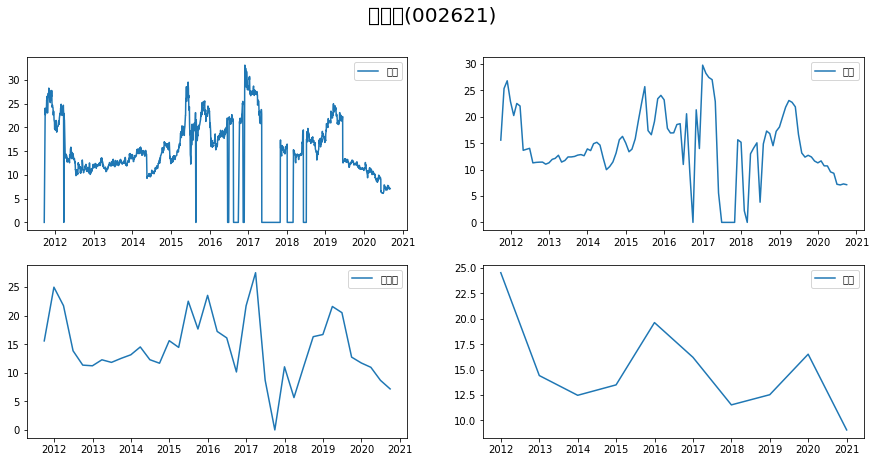

In [4]:
# 按照天，月，季度，年来显示美吉姆的走势
fig = plt.figure(figsize=[15, 7])
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('美吉姆(002621)', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()
plt.show()

In [5]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
#print(last_month)
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

最优模型:                                ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  109
Model:                     ARMA(1, 0)   Log Likelihood                -323.150
Method:                       css-mle   S.D. of innovations              4.677
Date:                Sun, 06 Sep 2020   AIC                            652.300
Time:                        18:58:33   BIC                            660.374
Sample:                    09-30-2011   HQIC                           655.574
                         - 09-30-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.3335      1.441      9.944      0.000      11.508      17.159
ar.L1.Price     0.6954      0.068     10.205      0.000       0.562       0.829
                                    Roots

                Price   forecast
2011-09-30  15.590000        NaN
2011-10-31  25.367500  15.207279
2011-11-30  26.827727  22.006632
2011-12-31  22.894545  23.022086
2012-01-31  20.243333  20.286920
2012-02-29  22.527619  18.443245
2012-03-31  22.050000  20.031756
2012-04-30  13.653529  19.699616
2012-05-31  13.848182  13.860642
2012-06-30  14.032000  13.996005
2012-07-31  11.274091  14.123833
2012-08-31  11.367391  12.205961
2012-09-30  11.408500  12.270843
2012-10-31  11.420000  12.299430
2012-11-30  11.025909  12.307427
2012-12-31  11.286190  12.033373
2013-01-31  11.942000  12.214375
2013-02-28  12.126000  12.670430
2013-03-31  12.717619  12.798386
2013-04-30  11.426111  13.209802
2013-05-31  11.722273  12.311677
2013-06-30  12.394706  12.517630
2013-07-31  12.399565  12.985246
2013-08-31  12.492727  12.988625
2013-09-30  12.739474  13.053411
2013-10-31  12.845556  13.225000
2013-11-30  12.629524  13.298770
2013-12-31  13.919091  13.148540
2014-01-31  13.603810  14.045316
2014-02-28

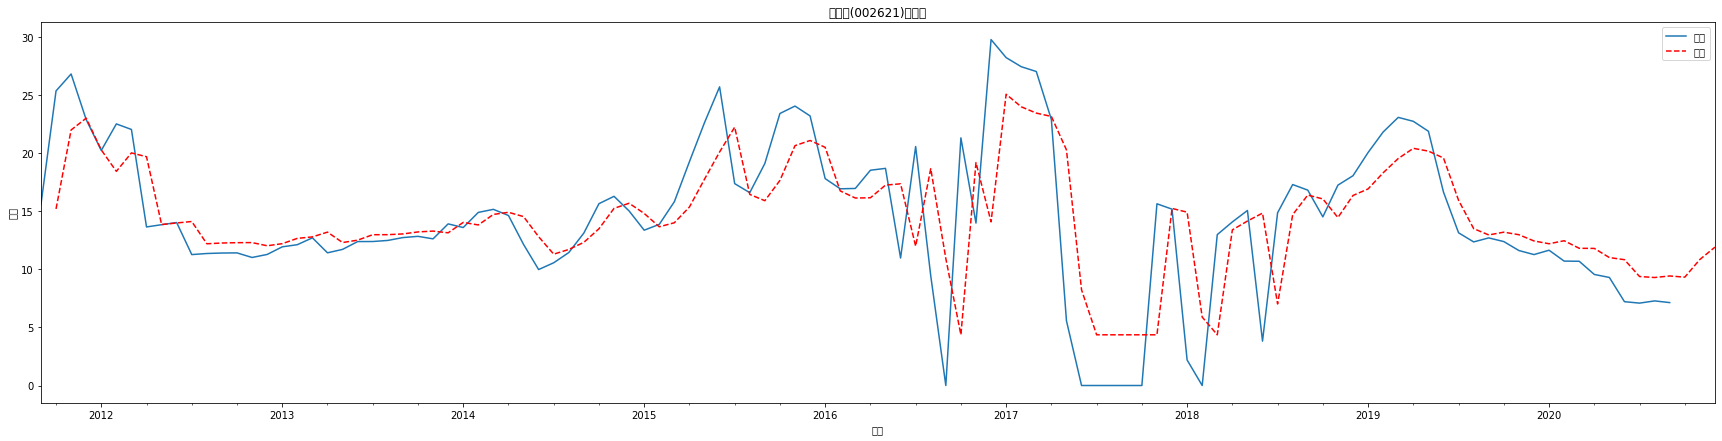

In [6]:
# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))
# 第一个元素不正确，设置为NaN
df_month2['forecast'][0] = np.NaN
print(df_month2)

# 美吉姆预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际')
df_month2.forecast.plot(color='r', ls='--', label='预测')
plt.legend()
plt.title('美吉姆(002621)（月）')
plt.xlabel('时间')
plt.ylabel('价格')
plt.show()